# Hyper

A script to detect the most hyped (popular) bands of a festival

In [11]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [12]:
import sqlite3
import pandas as pd
import string
import unicodedata

## Load Data

In [13]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [16]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
print("{} bands read".format(len(bands)))
#bands.head()

10 bands read


In [23]:
# read tweets from db
tweets = pd.read_sql_query("SELECT * FROM TweetsRaw;", connection)
print("{} tweets read".format(len(tweets)))
#tweets.head()
#tweets.describe()

1000 tweets read


## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [18]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [24]:
# extract bands for each tweet
tweets['bands'] = tweets.apply(extract_bands, axis=1)

In [20]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """

    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })

In [28]:
# construct the list of tweets per band
band_tweets_list = []
tweets.apply(band_partition, axis=1);

# create a dataframe from the previous list
band_tweets = pd.DataFrame.from_dict(band_tweets_list)
print("{} band-tweets".format(band_tweets.shape[0]))
#band_tweets.head()

936 band-tweets


## Explore Band-Tweet Data

In [29]:
# Count tweets per band
print(band_tweets.groupby('bandCodedName').size())

bandCodedName
!!!                99
7notas7colores     79
angelolsen         95
animic            109
arcadefire         95
aurorahalal       102
boniver           109
converge           56
mishima            80
theafghanwhigs    112
dtype: int64


In [30]:
# Count measures of a given band
bandCodedName = 'mishima'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about mishima:  80
Total Favs of mishima: 3979
Total RTs of mishima:  4455


## Explore Band-Tweet Timelines

In [33]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


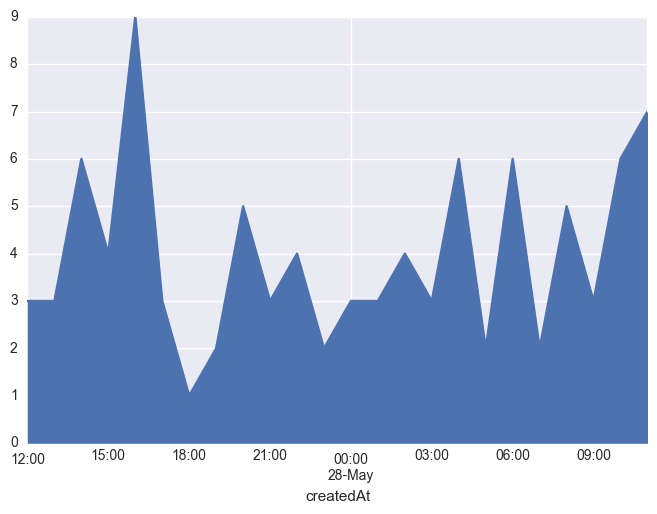

In [128]:
# timeline of tweet creations
# https://chrisalbon.com/python/pandas_group_data_by_time.html
bandCodedName = 'arcadefire'
single_band_tweets = band_tweets[band_tweets['bandCodedName'] == bandCodedName]
single_band_tweets['createdAt'] = pd.to_datetime(single_band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0200 %Y')
single_band_tweets.index = single_band_tweets['createdAt']
single_band_tweets.resample('H').count()['bandId'].plot(kind='area')

## Hyper Score & Ranking

In [ ]:
# Create the dataframe with one row per band and all the metrics associated

# sort the dataframe by X